In [1]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint
import spacy
import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt 
import pandas as pd
import os

# 2. Executive summary text

In [2]:
# prepare data
directory = 'output/unprocessed/summary/'
documents = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file

    if (os.path.isfile(f) and (".DS_Store" not in f)):
        # print(f)
        with open(f, 'r', encoding="utf8") as fp:
            currentfiledata = fp.read()
        documents.append(currentfiledata.lower())

In [3]:
# be sure to split text in each document into tokens before feeding into Dictionary
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

def remove_stopwords(text):
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

def stemwords(words):
    global ps
    result = []
    for word in words:
        result.append(ps.stem(word))
    return result

documents2 = [stemwords(remove_stopwords(doc.split())) for doc in documents]
id2word = Dictionary(documents2)
# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in documents2]

In [4]:
# [[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

In [5]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=20, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"water" + 0.011*"polici" + 0.008*"financ" + 0.006*"govern" + '
  '0.006*"countri" + 0.006*"use" + 0.006*"manag" + 0.006*"oecd" + '
  '0.005*"increas" + 0.004*"invest"'),
 (1,
  '0.018*"water" + 0.010*"financ" + 0.007*"servic" + 0.007*"develop" + '
  '0.006*"invest" + 0.006*"manag" + 0.006*"polici" + 0.005*"need" + '
  '0.005*"countri" + 0.005*"financi"'),
 (2,
  '0.021*"water" + 0.011*"financ" + 0.007*"polici" + 0.006*"sector" + '
  '0.006*"develop" + 0.005*"countri" + 0.005*"need" + 0.005*"servic" + '
  '0.004*"manag" + 0.004*"financi"'),
 (3,
  '0.037*"water" + 0.012*"polici" + 0.008*"manag" + 0.007*"govern" + '
  '0.006*"resourc" + 0.006*"oecd" + 0.005*"develop" + 0.004*"use" + '
  '0.004*"countri" + 0.004*"cost"'),
 (4,
  '0.031*"water" + 0.013*"polici" + 0.008*"alloc" + 0.007*"manag" + '
  '0.006*"govern" + 0.006*"use" + 0.005*"improv" + 0.005*"cost" + '
  '0.005*"resourc" + 0.005*"develop"'),
 (5,
  '0.053*"water" + 0.014*"polici" + 0.010*"manag" + 0.007*"financ" + 

In [6]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents2, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

\nCoherence Score:  0.2623795263522086


In [7]:
# Try mallet LDA model (tends to have better topic coherence scores)
os.environ.update({'MALLET_HOME':r'mallet-2.0.8'})
mallet_path = r'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=documents2, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('water', 0.09374419899758678),
   ('polici', 0.03211434935956933),
   ('benefit', 0.030814924819008726),
   ('pollut', 0.028958604046779284),
   ('qualiti', 0.021718953035084462),
   ('cost', 0.019677000185632076),
   ('environment', 0.01392240579172081),
   ('address', 0.012994245405606088),
   ('agricultur', 0.012808613328383145),
   ('reduc', 0.01169482086504548)]),
 (1,
  [('water', 0.060263653483992465),
   ('polici', 0.04947782913884609),
   ('govern', 0.04314329738058552),
   ('oecd', 0.01660674542030474),
   ('effect', 0.014723506248929978),
   ('level', 0.014381099126861838),
   ('co-ordin', 0.0140386920047937),
   ('countri', 0.01335387776065742),
   ('institut', 0.012669063516521143),
   ('implement', 0.012155452833418935)]),
 (2,
  [('water', 0.036883356385431075),
   ('resourc', 0.03550023052097741),
   ('alloc', 0.03434762563393269),
   ('groundwat', 0.022130013831258646),
   ('econom', 0.019363762102351315),
   ('oecd', 0.014983863531581374),
   ('manag', 0.0138

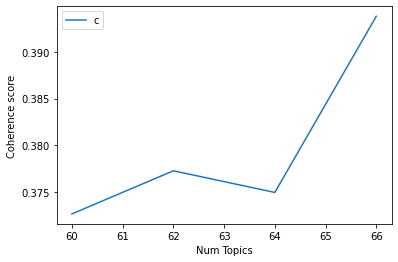

In [8]:
# compute optimal number of topics (max topic coherence scores)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=documents2, start=60, limit=68, step=2)

# Show graph
limit=68; start=60; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
# compute the model with the optimal coherence score
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 66 topics gives the highest coherence score \
of 0.39380458098736415


In [10]:
# Convert Mallet model to vanilla LDA model so that we can visualize it using PYLDavis
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [11]:
# plot topics for optimal LDA model
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, R=10)
p

/Users/kodymoodley/Documents/local-coding/topic-modelling-ctm/ctmenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/kodymoodley/Documents/local-coding/topic-modelling-ctm/ctmenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/kodymoodley/Documents/local-coding/topic-modelling-ctm/ctmenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
65    -0.371520 -0.064107       1        1  4.921092
0     -0.193681  0.022063       2        1  3.765317
59     0.028991  0.187792       3        1  3.121133
48    -0.357101 -0.057764       4        1  3.091061
45    -0.056705  0.131687       5        1  2.706048
...         ...       ...     ...      ...       ...
34     0.031909  0.007471      62        1  0.695218
14    -0.077426  0.080265      63        1  0.652701
21    -0.041220  0.008757      64        1  0.647671
61     0.043072  0.002961      65        1  0.627921
6      0.038593 -0.023602      66        1  0.502011

[66 rows x 5 columns], topic_info=          Term         Freq        Total Category  logprob  loglift
331      water  2252.000000  2252.000000  Default  10.0000  10.0000
231     polici   628.000000   628.000000  Default   9.0000   9.0000
460     financ   385.000000   385.000000  Default   8.0000   8.0000
195      manag   391.000000   391.000000  Default   7.0000   7.0000
412    countri   319.000000   319.000000  Default   6.0000   6.0000
...        ...          ...          ...      ...      ...      ...
2774    season     4.416931     7.588814  Topic66  -4.0733   4.7531
414   country’     6.625396    17.643907  Topic66  -3.6678   4.3148
1488    stress     5.521164    15.174947  Topic66  -3.8501   4.2832
1157     basin     8.833862    90.915589  Topic66  -3.3801   2.9630
168   introduc     5.521164    18.725448  Topic66  -3.8501   4.0730

[1923 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1099     42  0.910552   (0.54%
5082     34  0.933544     (20%
1923     25  0.940064  (2015).
2332     35  0.907714   (2017)
5845     51  1.061251  (2020),
...     ...       ...      ...
338      52  0.094235        •
1508     31  0.378246        ●
1508     38  0.605193        ●
1346     44  1.002169        
4365     23  0.993178       ��

[3351 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[66, 1, 60, 49, 46, 47, 56, 2, 4, 57, 20, 25, 13, 45, 44, 19, 52, 26, 41, 33, 43, 61, 24, 11, 34, 12, 39, 32, 6, 3, 30, 36, 50, 42, 55, 9, 8, 48, 5, 31, 18, 21, 14, 37, 10, 51, 53, 38, 29, 27, 16, 54, 59, 23, 64, 28, 63, 58, 40, 17, 65, 35, 15, 22, 62, 7])